In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import warnings
from sklearn import tree
from sklearn.model_selection import train_test_split
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Matplotlib is building the font cache; this may take a moment.


In [3]:
train_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Train.csv'
test_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Test.csv'

In [5]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]


train = pd.read_csv(train_url,header=None, names = col_names)

test = pd.read_csv(test_url, header=None, names = col_names)

print('Dimensions of the Training set:',train.shape)
print('Dimensions of the Test set:',test.shape)

Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22544, 42)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22544 non-null  int64  
 1   protocol_type                22544 non-null  object 
 2   service                      22544 non-null  object 
 3   flag                         22544 non-null  object 
 4   src_bytes                    22544 non-null  int64  
 5   dst_bytes                    22544 non-null  int64  
 6   land                         22544 non-null  int64  
 7   wrong_fragment               22544 non-null  int64  
 8   urgent                       22544 non-null  int64  
 9   hot                          22544 non-null  int64  
 10  num_failed_logins            22544 non-null  int64  
 11  logged_in                    22544 non-null  int64  
 12  num_compromised              22544 non-null  int64  
 13  root_shell      

In [8]:
print('Label distribution Training set:')
print(train['label'].value_counts())
print()
print('Label distribution Test set:')
print(test['label'].value_counts())

Label distribution Training set:
label
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

Label distribution Test set:
label
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattac

In [9]:
#Rewriting
train["label"] = train["label"].apply(lambda x: "normal" if x == "normal" else "anomalous")
test["label"] = test["label"].apply(lambda x: "normal" if x == "normal" else "anomalous")
# Checking the distribution after the change
print(train["label"].value_counts())
print()
print(test["label"].value_counts())

label
normal       67343
anomalous    58630
Name: count, dtype: int64

label
anomalous    12833
normal        9711
Name: count, dtype: int64


In [10]:
missing_columns= [col for col in train.columns if train[col].isnull().sum() > 0]
print(f"Number of missing columns: {missing_columns} ")

Number of missing columns: [] 


In [11]:
# Removing duplicate rows
train.drop_duplicates(inplace=True)

# Check the shape of the dataset after removing duplicates
print(f"New shape of the dataset: {train.shape}")

New shape of the dataset: (125964, 42)


In [12]:
missing_columns= [col for col in test.columns if test[col].isnull().sum() > 0]
print(f"Number of missing columns: {missing_columns} ")

Number of missing columns: [] 


In [13]:
print(f"Number of duplicate rows: {test.duplicated().sum()}")


Number of duplicate rows: 3


In [14]:
# Removing duplicate rows
test.drop_duplicates(inplace=True)

# Check the shape of the dataset after removing duplicates
print(f"New shape of the dataset: {test.shape}")

New shape of the dataset: (22541, 42)


<Axes: xlabel='label', ylabel='count'>

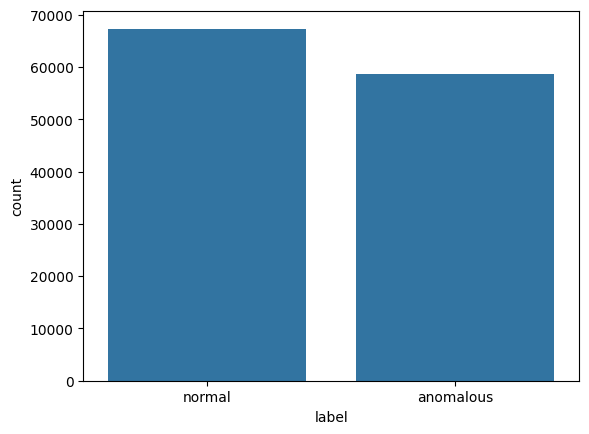

In [15]:
import seaborn as sns
sns.countplot(x=train["label"])

In [16]:
import pandas as pd

# Assuming df is your DataFrame
def check_constant_columns(test):
    constant_columns = [col for col in test.columns if test[col].nunique() == 1]
    return constant_columns

# Example usage
constant_cols = check_constant_columns(test)
if constant_cols:
    print(f"Columns with the same value across all rows: {constant_cols}")
else:
    print("No columns have the same value across all rows.")

Columns with the same value across all rows: ['num_outbound_cmds']


In [17]:
test["num_outbound_cmds"]

0        0
1        0
2        0
3        0
4        0
        ..
22539    0
22540    0
22541    0
22542    0
22543    0
Name: num_outbound_cmds, Length: 22541, dtype: int64

In [18]:
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [19]:
train.describe(include="object")

,protocol_type,service,flag,label
count,125964,125964,125964,125964
unique,3,70,11,2
top,tcp,http,SF,normal
freq,102689,40338,74936,67343


In [20]:
test.describe(include="object")

,protocol_type,service,flag,label
count,22541,22541,22541,22541
unique,3,64,11,2
top,tcp,http,SF,anomalous
freq,18877,7853,14875,12830


In [21]:
from sklearn.preprocessing import LabelEncoder
 
def LabelEncoding(df):
    for col in df.columns:
        if df[col].dtype == 'object':
                label_encoder = LabelEncoder()
                df[col] = label_encoder.fit_transform(df[col])

LabelEncoding(train)
LabelEncoding(test)

In [22]:
test["protocol_type"].head()

0    1
1    1
2    1
3    0
4    1
Name: protocol_type, dtype: int64

In [23]:
len(train)/len(test)

5.588217026751253

In [24]:
# Splitting the Training Dataset into X_train (features) and y_train (label)
X_train = train.drop(["label"], axis=1)
y_train = train["label"]
X_test = test.drop(["label"], axis=1)
y_test = test["label"]

In [25]:
print(f"{X_train.shape}")
print(f"{X_test.shape}")
print(f"{y_train.shape}")
print(f"{y_test.shape}")

(125964, 40)
(22541, 40)
(125964,)
(22541,)


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

np.random.seed(42)

rfc = RandomForestClassifier() 

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

In [29]:
import itertools 
from tabulate import tabulate

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate']

In [28]:
!pip install tabulate


1906.66s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [30]:
X_train = X_train[selected_features]
# Training dataset is updated to include only the selected features (10 features chosen by RFE)
X_test = X_test[selected_features]

In [31]:
np.array(X_train)

array([[1.0e+00, 2.0e+01, 9.0e+00, ..., 0.0e+00, 2.5e+01, 1.7e-01],
       [2.0e+00, 4.4e+01, 9.0e+00, ..., 1.5e-01, 1.0e+00, 0.0e+00],
       [1.0e+00, 4.9e+01, 5.0e+00, ..., 7.0e-02, 2.6e+01, 1.0e-01],
       ...,
       [1.0e+00, 5.4e+01, 9.0e+00, ..., 0.0e+00, 3.0e+01, 1.2e-01],
       [1.0e+00, 3.0e+01, 5.0e+00, ..., 5.0e-02, 8.0e+00, 3.0e-02],
       [1.0e+00, 2.0e+01, 9.0e+00, ..., 0.0e+00, 7.7e+01, 3.0e-01]])

In [32]:
import time
from sklearn.ensemble import RandomForestClassifier

np.random.seed(42)

#Instantiate Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100)
start_time = time.time()

#Fitting the model to the data 
clf.fit(X_train, y_train.values.ravel())

end_time = time.time()
print("Training time: ", end_time-start_time)


Training time:  3.372988224029541


In [33]:
start_time = time.time()
# Compare predictions to truth labels to evaluate the model
y_preds = clf.predict(X_test)
end_time = time.time()
print("Testing time: ", end_time-start_time)

Testing time:  0.15715312957763672


In [34]:
np.mean(y_preds == y_test)

0.7888292444878222

In [35]:
clf.score(X_train, y_train)

0.9999285510145756

In [36]:
from sklearn.metrics import accuracy_score 
accuracy_score(y_test, y_preds)

0.7888292444878222

In [40]:
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from xgboost import XGBClassifier

# Gradient Boosting Model with hyperparameter tuning
gbc = GradientBoostingClassifier(random_state=42)
param_grid_gbc = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5],
}
grid_gbc = GridSearchCV(gbc, param_grid_gbc, cv=5)
grid_gbc.fit(X_train, y_train)
print("Best parameters for Gradient Boosting:", grid_gbc.best_params_)
print("Best cross-validation score for Gradient Boosting:", grid_gbc.best_score_)

# Stacking Ensemble
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gbc', grid_gbc.best_estimator_),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
]

stacked_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacked_model.fit(X_train, y_train)
stacked_score = cross_val_score(stacked_model, X_train, y_train, cv=5).mean()
print("Stacked Model Cross-Validation Score:", stacked_score)


Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best cross-validation score for Gradient Boosting: 0.9984439999356131


/opt/anaconda3/envs/py311_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:01:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/py311_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:02:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/py311_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:02:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/py311_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:02:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn

Stacked Model Cross-Validation Score: 0.9986504089981393


In [41]:
from sklearn.metrics import accuracy_score 
accuracy_score(y_test, y_preds)

0.7888292444878222

In [42]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

# Load your dataset (use your dataset URL or local path)
train_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Train.csv'
test_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Test.csv'

train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

# Preprocessing
def preprocess_data(df):
    label_encoder = LabelEncoder()
    df['label'] = df['label'].apply(lambda x: 'normal' if x == 'normal' else 'anomalous')
    df = pd.get_dummies(df, columns=['protocol_type', 'service', 'flag'])  # One-hot encoding for categorical
    df['label'] = label_encoder.fit_transform(df['label'])
    return df

train = preprocess_data(train)
test = preprocess_data(test)

X_train = train.drop('label', axis=1).values
y_train = train['label'].values
X_test = test.drop('label', axis=1).values
y_test = test['label'].values

# Feature Mapping (Random Feature Transformation)
def feature_mapping(X, n_nodes=1000):
    np.random.seed(42)
    W = np.random.normal(0, 1, (X.shape[1], n_nodes))
    bias = np.random.normal(0, 1, n_nodes)
    Z = np.dot(X, W) + bias  # Linear mapping
    return np.tanh(Z)  # Non-linear transformation

# Enhancement Nodes (Adding randomness to enhance features)
def enhancement_nodes(mapped_features, n_enhancement_nodes=500):
    np.random.seed(42)
    W = np.random.normal(0, 1, (mapped_features.shape[1], n_enhancement_nodes))
    bias = np.random.normal(0, 1, n_enhancement_nodes)
    enhancement = np.dot(mapped_features, W) + bias
    return np.tanh(enhancement)

# BLS Training
def train_bls(X, y, n_mapped=1000, n_enhancement=500, reg=0.01):
    mapped_features = feature_mapping(X, n_nodes=n_mapped)
    enhanced_features = enhancement_nodes(mapped_features, n_enhancement_nodes=n_enhancement)
    
    # Concatenate original features with enhanced features
    bls_features = np.concatenate([mapped_features, enhanced_features], axis=1)
    
    # Ridge regression for final output layer
    model = Ridge(alpha=reg, fit_intercept=False)
    model.fit(bls_features, y)
    return model, mapped_features, enhanced_features

# BLS Prediction
def predict_bls(model, X, mapped_features, enhanced_features):
    bls_features = np.concatenate([mapped_features, enhanced_features], axis=1)
    return model.predict(bls_features)

# Training and Prediction
model, mapped_features_train, enhanced_features_train = train_bls(X_train, y_train)
y_pred_train = predict_bls(model, X_train, mapped_features_train, enhanced_features_train)
y_pred_train = np.where(y_pred_train >= 0.5, 1, 0)  # Convert probabilities to binary class

# Evaluation
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", train_accuracy)

# Testing the model
mapped_features_test = feature_mapping(X_test, n_nodes=1000)
enhanced_features_test = enhancement_nodes(mapped_features_test, n_enhancement_nodes=500)
y_pred_test = predict_bls(model, X_test, mapped_features_test, enhanced_features_test)
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)

# Evaluate on test set
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_accuracy)


KeyError: 'label'

In [43]:
print(train.columns)



Index(['0', 'tcp', 'ftp_data', 'SF', '491', '0.1', '0.2', '0.3', '0.4', '0.5',
       '0.6', '0.7', '0.8', '0.9', '0.10', '0.11', '0.12', '0.13', '0.14',
       '0.15', '0.16', '0.18', '2', '2.1', '0.19', '0.20', '0.21', '0.22', '1',
       '0.23', '0.24', '150', '25', '0.17', '0.03', '0.17.1', '0.25', '0.26',
       '0.27', '0.05', '0.28', 'normal'],
      dtype='object')


In [44]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge

# Load your dataset
train_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Train.csv'
test_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Test.csv'

train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

# Rename the last column to 'label' to match the code requirements
train = train.rename(columns={'normal': 'label'})
test = test.rename(columns={'normal': 'label'})

# Preprocessing function
def preprocess_data(df):
    label_encoder = LabelEncoder()
    df['label'] = df['label'].apply(lambda x: 'normal' if x == 'normal' else 'anomalous')
    df = pd.get_dummies(df, columns=['protocol_type', 'service', 'flag'])  # One-hot encoding for categorical
    df['label'] = label_encoder.fit_transform(df['label'])
    return df

# Apply preprocessing
train = preprocess_data(train)
test = preprocess_data(test)

# Split data into features and labels
X_train = train.drop('label', axis=1).values
y_train = train['label'].values
X_test = test.drop('label', axis=1).values
y_test = test['label'].values

# Define the feature mapping function
def feature_mapping(X, n_nodes=1000):
    np.random.seed(42)
    W = np.random.normal(0, 1, (X.shape[1], n_nodes))
    bias = np.random.normal(0, 1, n_nodes)
    Z = np.dot(X, W) + bias  # Linear mapping
    return np.tanh(Z)  # Non-linear transformation

# Define the enhancement nodes function
def enhancement_nodes(mapped_features, n_enhancement_nodes=500):
    np.random.seed(42)
    W = np.random.normal(0, 1, (mapped_features.shape[1], n_enhancement_nodes))
    bias = np.random.normal(0, 1, n_enhancement_nodes)
    enhancement = np.dot(mapped_features, W) + bias
    return np.tanh(enhancement)

# Define the BLS training function
def train_bls(X, y, n_mapped=1000, n_enhancement=500, reg=0.01):
    mapped_features = feature_mapping(X, n_nodes=n_mapped)
    enhanced_features = enhancement_nodes(mapped_features, n_enhancement_nodes=n_enhancement)
    
    # Concatenate original features with enhanced features
    bls_features = np.concatenate([mapped_features, enhanced_features], axis=1)
    
    # Ridge regression for final output layer
    model = Ridge(alpha=reg, fit_intercept=False)
    model.fit(bls_features, y)
    return model, mapped_features, enhanced_features

# Define the BLS prediction function
def predict_bls(model, X, mapped_features, enhanced_features):
    bls_features = np.concatenate([mapped_features, enhanced_features], axis=1)
    return model.predict(bls_features)

# Train the BLS model
model, mapped_features_train, enhanced_features_train = train_bls(X_train, y_train)

# Make predictions on training data
y_pred_train = predict_bls(model, X_train, mapped_features_train, enhanced_features_train)
y_pred_train = np.where(y_pred_train >= 0.5, 1, 0)  # Convert probabilities to binary class

# Evaluate training accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", train_accuracy)

# Test the model
mapped_features_test = feature_mapping(X_test, n_nodes=1000)
enhanced_features_test = enhancement_nodes(mapped_features_test, n_enhancement_nodes=500)
y_pred_test = predict_bls(model, X_test, mapped_features_test, enhanced_features_test)
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)

# Evaluate test accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_accuracy)


KeyError: "None of [Index(['protocol_type', 'service', 'flag'], dtype='object')] are in the [columns]"

In [45]:
print("Train columns:", train.columns)
print("Test columns:", test.columns)


Train columns: Index(['0', 'tcp', 'ftp_data', 'SF', '491', '0.1', '0.2', '0.3', '0.4', '0.5',
       '0.6', '0.7', '0.8', '0.9', '0.10', '0.11', '0.12', '0.13', '0.14',
       '0.15', '0.16', '0.18', '2', '2.1', '0.19', '0.20', '0.21', '0.22', '1',
       '0.23', '0.24', '150', '25', '0.17', '0.03', '0.17.1', '0.25', '0.26',
       '0.27', '0.05', '0.28', 'label'],
      dtype='object')
Test columns: Index(['0', 'tcp', 'private', 'REJ', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6',
       '0.7', '0.8', '0.9', '0.10', '0.11', '0.12', '0.13', '0.14', '0.15',
       '0.16', '0.17', '0.18', '229', '10', '0.19', '0.20', '1', '1.1', '0.04',
       '0.06', '0.21', '255', '10.1', '0.04.1', '0.06.1', '0.22', '0.23',
       '0.24', '0.25', '1.2', '1.3', 'neptune'],
      dtype='object')


In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 42 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   0         125972 non-null  int64  
 1   tcp       125972 non-null  object 
 2   ftp_data  125972 non-null  object 
 3   SF        125972 non-null  object 
 4   491       125972 non-null  int64  
 5   0.1       125972 non-null  int64  
 6   0.2       125972 non-null  int64  
 7   0.3       125972 non-null  int64  
 8   0.4       125972 non-null  int64  
 9   0.5       125972 non-null  int64  
 10  0.6       125972 non-null  int64  
 11  0.7       125972 non-null  int64  
 12  0.8       125972 non-null  int64  
 13  0.9       125972 non-null  int64  
 14  0.10      125972 non-null  int64  
 15  0.11      125972 non-null  int64  
 16  0.12      125972 non-null  int64  
 17  0.13      125972 non-null  int64  
 18  0.14      125972 non-null  int64  
 19  0.15      125972 non-null  int64  
 20  0.16

In [49]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge

# Column names as you provided
col_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes",
    "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

# Load dataset with explicit column names
train = pd.read_csv(train_url, header=None, names=col_names)
test = pd.read_csv(test_url, header=None, names=col_names)

print('Dimensions of the Training set:', train.shape)
print('Dimensions of the Test set:', test.shape)

# Preprocessing function
def preprocess_data(df):
    label_encoder = LabelEncoder()
    # Convert 'label' to binary classes ('normal' and 'anomalous')
    df['label'] = df['label'].apply(lambda x: 'normal' if x == 'normal' else 'anomalous')
    df = pd.get_dummies(df, columns=['protocol_type', 'service', 'flag'])  # One-hot encoding for categorical
    df['label'] = label_encoder.fit_transform(df['label'])
    return df

# Apply preprocessing to both train and test datasets
train = preprocess_data(train)
test = preprocess_data(test)

# Split data into features and labels
X_train = train.drop('label', axis=1).values
y_train = train['label'].values
X_test = test.drop('label', axis=1).values
y_test = test['label'].values

# Define BLS-specific functions
def feature_mapping(X, n_nodes=1000):
    np.random.seed(42)
    W = np.random.normal(0, 1, (X.shape[1], n_nodes))
    bias = np.random.normal(0, 1, n_nodes).reshape(1, n_nodes)  # Ensures bias is 2D
    Z = np.dot(X, W) + bias  # Linear mapping
    Z = np.array(Z)  # Ensure Z is an array
    print("Feature Mapping Shape:", Z.shape)  # Debugging statement to check dimensions
    return np.tanh(Z)  # Apply non-linear transformation

def enhancement_nodes(mapped_features, n_enhancement_nodes=500):
    np.random.seed(42)
    W = np.random.normal(0, 1, (mapped_features.shape[1], n_enhancement_nodes))
    bias = np.random.normal(0, 1, n_enhancement_nodes).reshape(1, n_enhancement_nodes)  # Ensure 2D for broadcasting
    enhancement = np.dot(mapped_features, W) + bias
    enhancement = np.array(enhancement)  # Ensure enhancement is an array
    print("Enhancement Nodes Shape:", enhancement.shape)  # Debugging statement to check dimensions
    return np.tanh(enhancement)
def train_bls(X, y, n_mapped=1000, n_enhancement=500, reg=0.01):
    mapped_features = feature_mapping(X, n_nodes=n_mapped)
    enhanced_features = enhancement_nodes(mapped_features, n_enhancement_nodes=n_enhancement)
    bls_features = np.concatenate([mapped_features, enhanced_features], axis=1)
    model = Ridge(alpha=reg, fit_intercept=False)
    model.fit(bls_features, y)
    return model, mapped_features, enhanced_features

def predict_bls(model, X, mapped_features, enhanced_features):
    bls_features = np.concatenate([mapped_features, enhanced_features], axis=1)
    return model.predict(bls_features)

# Train the BLS model
model, mapped_features_train, enhanced_features_train = train_bls(X_train, y_train)

# Predict on training set
y_pred_train = predict_bls(model, X_train, mapped_features_train, enhanced_features_train)
y_pred_train = np.where(y_pred_train >= 0.5, 1, 0)  # Convert to binary

# Training accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", train_accuracy)

# Test the model
mapped_features_test = feature_mapping(X_test, n_nodes=1000)
enhanced_features_test = enhancement_nodes(mapped_features_test, n_enhancement_nodes=500)
y_pred_test = predict_bls(model, X_test, mapped_features_test, enhanced_features_test)
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)

# Test accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_accuracy)


Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22544, 42)
Feature Mapping Shape: (125973, 1000)


TypeError: loop of ufunc does not support argument 0 of type float which has no callable tanh method

In [50]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge

# Set column names and load datasets
col_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes",
    "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

train_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Train.csv'
test_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Test.csv'

train = pd.read_csv(train_url, header=None, names=col_names)
test = pd.read_csv(test_url, header=None, names=col_names)

# Preprocessing
def preprocess_data(df):
    label_encoder = LabelEncoder()
    df['label'] = df['label'].apply(lambda x: 'normal' if x == 'normal' else 'anomalous')
    df = pd.get_dummies(df, columns=['protocol_type', 'service', 'flag'])
    df['label'] = label_encoder.fit_transform(df['label'])
    return df

train = preprocess_data(train)
test = preprocess_data(test)

X_train = train.drop('label', axis=1).values
y_train = train['label'].values
X_test = test.drop('label', axis=1).values
y_test = test['label'].values

# Feature Mapping with row-wise np.tanh
def feature_mapping(X, n_nodes=1000):
    np.random.seed(42)
    W = np.random.normal(0, 1, (X.shape[1], n_nodes))
    bias = np.random.normal(0, 1, n_nodes).reshape(1, n_nodes)
    Z = np.dot(X, W) + bias
    Z = np.array(Z, dtype=np.float64)  # Ensure all values are float64
    return np.vectorize(np.tanh)(Z)  # Apply tanh element-wise

# Enhancement Nodes with row-wise np.tanh
def enhancement_nodes(mapped_features, n_enhancement_nodes=500):
    np.random.seed(42)
    W = np.random.normal(0, 1, (mapped_features.shape[1], n_enhancement_nodes))
    bias = np.random.normal(0, 1, n_enhancement_nodes).reshape(1, n_enhancement_nodes)
    enhancement = np.dot(mapped_features, W) + bias
    enhancement = np.array(enhancement, dtype=np.float64)
    return np.vectorize(np.tanh)(enhancement)

# BLS Training
def train_bls(X, y, n_mapped=1000, n_enhancement=500, reg=0.01):
    mapped_features = feature_mapping(X, n_nodes=n_mapped)
    enhanced_features = enhancement_nodes(mapped_features, n_enhancement_nodes=n_enhancement)
    bls_features = np.concatenate([mapped_features, enhanced_features], axis=1)
    model = Ridge(alpha=reg, fit_intercept=False)
    model.fit(bls_features, y)
    return model, mapped_features, enhanced_features

# Prediction
def predict_bls(model, X, mapped_features, enhanced_features):
    bls_features = np.concatenate([mapped_features, enhanced_features], axis=1)
    return model.predict(bls_features)

# Train and Test
model, mapped_features_train, enhanced_features_train = train_bls(X_train, y_train)
y_pred_train = predict_bls(model, X_train, mapped_features_train, enhanced_features_train)
y_pred_train = np.where(y_pred_train >= 0.5, 1, 0)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", train_accuracy)

mapped_features_test = feature_mapping(X_test, n_nodes=1000)
enhanced_features_test = enhancement_nodes(mapped_features_test, n_enhancement_nodes=500)
y_pred_test = predict_bls(model, X_test, mapped_features_test, enhanced_features_test)
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_accuracy)


Training Accuracy: 0.986679685329396
Test Accuracy: 0.7862402413058907


In [50]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge

# Set column names and load datasets
col_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes",
    "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

train_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Train.csv'
test_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Test.csv'

train = pd.read_csv(train_url, header=None, names=col_names)
test = pd.read_csv(test_url, header=None, names=col_names)

# Preprocessing
def preprocess_data(df):
    label_encoder = LabelEncoder()
    df['label'] = df['label'].apply(lambda x: 'normal' if x == 'normal' else 'anomalous')
    df = pd.get_dummies(df, columns=['protocol_type', 'service', 'flag'])
    df['label'] = label_encoder.fit_transform(df['label'])
    return df

train = preprocess_data(train)
test = preprocess_data(test)

X_train = train.drop('label', axis=1).values
y_train = train['label'].values
X_test = test.drop('label', axis=1).values
y_test = test['label'].values

# Feature Mapping with row-wise np.tanh
def feature_mapping(X, n_nodes=1000):
    np.random.seed(42)
    W = np.random.normal(0, 1, (X.shape[1], n_nodes))
    bias = np.random.normal(0, 1, n_nodes).reshape(1, n_nodes)
    Z = np.dot(X, W) + bias
    Z = np.array(Z, dtype=np.float64)  # Ensure all values are float64
    return np.vectorize(np.tanh)(Z)  # Apply tanh element-wise

# Enhancement Nodes with row-wise np.tanh
def enhancement_nodes(mapped_features, n_enhancement_nodes=500):
    np.random.seed(42)
    W = np.random.normal(0, 1, (mapped_features.shape[1], n_enhancement_nodes))
    bias = np.random.normal(0, 1, n_enhancement_nodes).reshape(1, n_enhancement_nodes)
    enhancement = np.dot(mapped_features, W) + bias
    enhancement = np.array(enhancement, dtype=np.float64)
    return np.vectorize(np.tanh)(enhancement)

# BLS Training
def train_bls(X, y, n_mapped=1000, n_enhancement=500, reg=0.01):
    mapped_features = feature_mapping(X, n_nodes=n_mapped)
    enhanced_features = enhancement_nodes(mapped_features, n_enhancement_nodes=n_enhancement)
    bls_features = np.concatenate([mapped_features, enhanced_features], axis=1)
    model = Ridge(alpha=reg, fit_intercept=False)
    model.fit(bls_features, y)
    return model, mapped_features, enhanced_features

# Prediction
def predict_bls(model, X, mapped_features, enhanced_features):
    bls_features = np.concatenate([mapped_features, enhanced_features], axis=1)
    return model.predict(bls_features)

# Train and Test
model, mapped_features_train, enhanced_features_train = train_bls(X_train, y_train)
y_pred_train = predict_bls(model, X_train, mapped_features_train, enhanced_features_train)
y_pred_train = np.where(y_pred_train >= 0.5, 1, 0)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", train_accuracy)

mapped_features_test = feature_mapping(X_test, n_nodes=1000)
enhanced_features_test = enhancement_nodes(mapped_features_test, n_enhancement_nodes=500)
y_pred_test = predict_bls(model, X_test, mapped_features_test, enhanced_features_test)
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_accuracy)


Training Accuracy: 0.986679685329396
Test Accuracy: 0.7862402413058907


In [51]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Set column names and load datasets
col_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes",
    "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

# Load the dataset
train_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Train.csv'
test_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Test.csv'

train = pd.read_csv(train_url, header=None, names=col_names)
test = pd.read_csv(test_url, header=None, names=col_names)

# Preprocessing with feature scaling and label encoding
def preprocess_data(df):
    label_encoder = LabelEncoder()
    df['label'] = df['label'].apply(lambda x: 'normal' if x == 'normal' else 'anomalous')
    df = pd.get_dummies(df, columns=['protocol_type', 'service', 'flag'])  # One-hot encoding
    df['label'] = label_encoder.fit_transform(df['label'])
    return df

train = preprocess_data(train)
test = preprocess_data(test)

X_train = train.drop('label', axis=1).values
y_train = train['label'].values
X_test = test.drop('label', axis=1).values
y_test = test['label'].values

# Scale features for better generalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reduce dimensions using PCA for feature selection
pca = PCA(n_components=30)  # Adjust n_components as needed
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Feature Mapping and Enhancement Functions
def feature_mapping(X, n_nodes=500):
    np.random.seed(42)
    W = np.random.normal(0, 1, (X.shape[1], n_nodes))
    bias = np.random.normal(0, 1, n_nodes).reshape(1, n_nodes)
    Z = np.dot(X, W) + bias
    return np.tanh(Z)

def enhancement_nodes(mapped_features, n_enhancement_nodes=250):
    np.random.seed(42)
    W = np.random.normal(0, 1, (mapped_features.shape[1], n_enhancement_nodes))
    bias = np.random.normal(0, 1, n_enhancement_nodes).reshape(1, n_enhancement_nodes)
    enhancement = np.dot(mapped_features, W) + bias
    return np.tanh(enhancement)

# Ridge regression with cross-validation for regularization tuning
def train_bls_with_cv(X, y, n_mapped=500, n_enhancement=250):
    mapped_features = feature_mapping(X, n_nodes=n_mapped)
    enhanced_features = enhancement_nodes(mapped_features, n_enhancement_nodes=n_enhancement)
    bls_features = np.concatenate([mapped_features, enhanced_features], axis=1)
    
    # Cross-validation for the best alpha (reg)
    param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
    ridge = Ridge(fit_intercept=False)
    grid = GridSearchCV(ridge, param_grid, scoring='accuracy', cv=5)
    grid.fit(bls_features, y)
    best_model = grid.best_estimator_
    
    return best_model, mapped_features, enhanced_features

# Train the BLS model with cross-validated regularization
model, mapped_features_train, enhanced_features_train = train_bls_with_cv(X_train, y_train)

# Predict on training set
y_pred_train = model.predict(np.concatenate([mapped_features_train, enhanced_features_train], axis=1))
y_pred_train = np.where(y_pred_train >= 0.5, 1, 0)
train_accuracy = accuracy_score(y_train, y_pred_train)

# Test the model on the test set
mapped_features_test = feature_mapping(X_test, n_nodes=500)
enhanced_features_test = enhancement_nodes(mapped_features_test, n_enhancement_nodes=250)
y_pred_test = model.predict(np.concatenate([mapped_features_test, enhanced_features_test], axis=1))
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)
test_accuracy = accuracy_score(y_test, y_pred_test)

train_accuracy, test_accuracy, grid.best_params_


ValueError: X has 116 features, but StandardScaler is expecting 122 features as input.

In [52]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Column names and data loading
col_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes",
    "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

train_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Train.csv'
test_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Test.csv'

train = pd.read_csv(train_url, header=None, names=col_names)
test = pd.read_csv(test_url, header=None, names=col_names)

# Combine and encode to ensure consistency
combined = pd.concat([train, test], keys=['train', 'test'])
combined['label'] = combined['label'].apply(lambda x: 'normal' if x == 'normal' else 'anomalous')
combined = pd.get_dummies(combined, columns=['protocol_type', 'service', 'flag'])

# Separate back into train and test datasets
train = combined.xs('train')
test = combined.xs('test')

# Split features and labels
X_train = train.drop('label', axis=1).values
y_train = train['label'].values
X_test = test.drop('label', axis=1).values
y_test = test['label'].values

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Scale features for better generalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Feature Mapping with fewer nodes to reduce complexity
def feature_mapping(X, n_nodes=500):
    np.random.seed(42)
    W = np.random.normal(0, 1, (X.shape[1], n_nodes))
    bias = np.random.normal(0, 1, n_nodes).reshape(1, n_nodes)
    Z = np.dot(X, W) + bias
    return np.tanh(Z)

# Enhancement Nodes with fewer nodes for regularization
def enhancement_nodes(mapped_features, n_enhancement_nodes=250):
    np.random.seed(42)
    W = np.random.normal(0, 1, (mapped_features.shape[1], n_enhancement_nodes))
    bias = np.random.normal(0, 1, n_enhancement_nodes).reshape(1, n_enhancement_nodes)
    enhancement = np.dot(mapped_features, W) + bias
    return np.tanh(enhancement)

# Ridge regression with cross-validation for regularization tuning
def train_bls_with_cv(X, y, n_mapped=500, n_enhancement=250):
    mapped_features = feature_mapping(X, n_nodes=n_mapped)
    enhanced_features = enhancement_nodes(mapped_features, n_enhancement_nodes=n_enhancement)
    bls_features = np.concatenate([mapped_features, enhanced_features], axis=1)
    
    # Cross-validation for the best alpha (reg)
    param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
    ridge = Ridge(fit_intercept=False)
    grid = GridSearchCV(ridge, param_grid, scoring='accuracy', cv=5)
    grid.fit(bls_features, y)
    best_model = grid.best_estimator_
    
    return best_model, mapped_features, enhanced_features

# Train the BLS model with cross-validated regularization
model, mapped_features_train, enhanced_features_train = train_bls_with_cv(X_train, y_train)

# Prediction and evaluation
def predict_bls(model, X, mapped_features, enhanced_features):
    bls_features = np.concatenate([mapped_features, enhanced_features], axis=1)
    return model.predict(bls_features)

# Predict on training set and evaluate accuracy
y_pred_train = predict_bls(model, X_train, mapped_features_train, enhanced_features_train)
y_pred_train = np.where(y_pred_train >= 0.5, 1, 0)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", train_accuracy)

# Test the model on the test set and evaluate accuracy
mapped_features_test = feature_mapping(X_test, n_nodes=500)
enhanced_features_test = enhancement_nodes(mapped_features_test, n_enhancement_nodes=250)
y_pred_test = predict_bls(model, X_test, mapped_features_test, enhanced_features_test)
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_accuracy)


/opt/anaconda3/envs/py311_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/py311_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/py311_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/py311_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
          

Training Accuracy: 0.9919982853468601
Test Accuracy: 0.7892122072391767


In [53]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Column names and data loading
col_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes",
    "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

train_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Train.csv'
test_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Test.csv'

train = pd.read_csv(train_url, header=None, names=col_names)
test = pd.read_csv(test_url, header=None, names=col_names)

# Combine and encode to ensure consistency
combined = pd.concat([train, test], keys=['train', 'test'])
combined['label'] = combined['label'].apply(lambda x: 'normal' if x == 'normal' else 'anomalous')
combined = pd.get_dummies(combined, columns=['protocol_type', 'service', 'flag'])

# Separate back into train and test datasets
train = combined.xs('train')
test = combined.xs('test')

# Split features and labels
X_train = train.drop('label', axis=1).values
y_train = train['label'].values
X_test = test.drop('label', axis=1).values
y_test = test['label'].values

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Scale features for better generalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Feature Mapping with fewer nodes to reduce complexity
def feature_mapping(X, n_nodes=500):
    np.random.seed(42)
    W = np.random.normal(0, 1, (X.shape[1], n_nodes))
    bias = np.random.normal(0, 1, n_nodes).reshape(1, n_nodes)
    Z = np.dot(X, W) + bias
    return np.tanh(Z)

# Enhancement Nodes with fewer nodes for regularization
def enhancement_nodes(mapped_features, n_enhancement_nodes=250):
    np.random.seed(42)
    W = np.random.normal(0, 1, (mapped_features.shape[1], n_enhancement_nodes))
    bias = np.random.normal(0, 1, n_enhancement_nodes).reshape(1, n_enhancement_nodes)
    enhancement = np.dot(mapped_features, W) + bias
    return np.tanh(enhancement)

# Ridge regression with cross-validation for regularization tuning
def train_bls_with_cv(X, y, n_mapped=500, n_enhancement=250):
    mapped_features = feature_mapping(X, n_nodes=n_mapped)
    enhanced_features = enhancement_nodes(mapped_features, n_enhancement_nodes=n_enhancement)
    bls_features = np.concatenate([mapped_features, enhanced_features], axis=1)
    
    # Cross-validation for the best alpha using MSE scoring
    param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
    ridge = Ridge(fit_intercept=False)
    grid = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5)
    grid.fit(bls_features, y)
    best_model = grid.best_estimator_
    
    return best_model, mapped_features, enhanced_features

# Train the BLS model with cross-validated regularization
model, mapped_features_train, enhanced_features_train = train_bls_with_cv(X_train, y_train)

# Prediction and evaluation
def predict_bls(model, X, mapped_features, enhanced_features):
    bls_features = np.concatenate([mapped_features, enhanced_features], axis=1)
    predictions = model.predict(bls_features)
    # Convert continuous predictions to binary labels
    return np.where(predictions >= 0.5, 1, 0)

# Predict on training set and evaluate accuracy
y_pred_train = predict_bls(model, X_train, mapped_features_train, enhanced_features_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", train_accuracy)

# Test the model on the test set and evaluate accuracy
mapped_features_test = feature_mapping(X_test, n_nodes=500)
enhanced_features_test = enhancement_nodes(mapped_features_test, n_enhancement_nodes=250)
y_pred_test = predict_bls(model, X_test, mapped_features_test, enhanced_features_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_accuracy)


Training Accuracy: 0.9919347796750098
Test Accuracy: 0.7877927608232789


In [54]:
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from xgboost import XGBClassifier
import numpy as np

# Gradient Boosting Model with hyperparameter tuning
gbc = GradientBoostingClassifier(random_state=42)
param_grid_gbc = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5],
}
grid_gbc = GridSearchCV(gbc, param_grid_gbc, cv=5)
grid_gbc.fit(X_train, y_train)
print("Best parameters for Gradient Boosting:", grid_gbc.best_params_)
print("Best cross-validation score for Gradient Boosting:", grid_gbc.best_score_)

# Cross-validation for XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_scores = cross_val_score(xgb, X_train, y_train, cv=5)
print(f"Mean cross-validation score for XGBoost: {np.mean(xgb_scores):.4f}")
print(f"Standard deviation of cross-validation scores for XGBoost: {np.std(xgb_scores):.4f}")

# Stacking Ensemble
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gbc', grid_gbc.best_estimator_),
    ('xgb', xgb)
]

stacked_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacked_model.fit(X_train, y_train)
stacked_score = cross_val_score(stacked_model, X_train, y_train, cv=5).mean()
print("Stacked Model Cross-Validation Score:", stacked_score)


Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best cross-validation score for Gradient Boosting: 0.9987933928015288


/opt/anaconda3/envs/py311_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:20:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/py311_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:20:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/py311_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:20:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/py311_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:20:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn

Mean cross-validation score for XGBoost: 0.9992
Standard deviation of cross-validation scores for XGBoost: 0.0002


/opt/anaconda3/envs/py311_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:21:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/py311_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:26:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/py311_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:26:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/py311_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:26:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn

Stacked Model Cross-Validation Score: 0.9991903048261349
